In [1]:
import os
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

# torchvision
import torchvision
import module_lsq as Q
from models.model import create_model
from configs import *

from xlwt import Workbook
import copy
import numpy as np
from utils import *
from functools import partial

import math
import time
import warnings

import matplotlib.pyplot as plt

# 1. nuLSQのチェック

1. activationのgrad scale on/off

In [61]:
dir_name_w_GS = "./work_dir/cifar/LSQ_non_uniform_only_activation/calculate_A_preresnet20_cifar100_2bit_SGD_CosineAnnealing_lr0.01-2/"
A_w_GS_mean_file_name = dir_name_w_GS + "A_mean.pt"
A_w_GS_std_file_name = dir_name_w_GS + "A_std.pt"

dir_name_wo_GS = "./work_dir/cifar/LSQ_non_uniform_only_activation/calculate_A_preresnet20_cifar100_2bit_SGD_CosineAnnealing_lr0.01-2_wo_GS/"
A_wo_GS_mean_file_name = dir_name_wo_GS + "A_mean.pt"
A_wo_GS_std_file_name = dir_name_wo_GS + "A_std.pt"

In [62]:
A_w_GS_mean = torch.load(A_w_GS_mean_file_name)
A_w_GS_std = torch.load(A_w_GS_std_file_name)
A_wo_GS_mean = torch.load(A_wo_GS_mean_file_name)
A_wo_GS_std = torch.load(A_wo_GS_std_file_name)

In [63]:
A_w_GS_mean_plt = torch.reshape(A_w_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wo_GS_mean_plt = torch.reshape(A_wo_GS_mean, (-1,)).to('cpu').detach().numpy().copy()

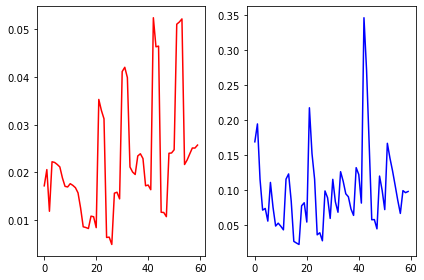

In [65]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_w_GS_mean_plt,color="red")
axes[0,1].plot(A_wo_GS_mean_plt,color="blue")
plt.show()

2. weightのgrad scale on/off

In [35]:
dir_name_w_GS = "./work_dir/cifar/LSQ_non_uniform_both_activation_weight/calculate_A_preresnet20_cifar100_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_wneg_GS_mean_file_name = dir_name_w_GS + "Awneg_mean.pt"
A_wneg_GS_std_file_name = dir_name_w_GS + "Awneg_std.pt"
A_wpos_GS_mean_file_name = dir_name_w_GS + "Awpos_mean.pt"
A_wpos_GS_std_file_name = dir_name_w_GS + "Awpos_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_w.pt"

In [36]:
A_wneg_GS_mean = torch.load(A_wneg_GS_mean_file_name)
A_wneg_GS_std = torch.load(A_wneg_GS_std_file_name)
A_wpos_GS_mean = torch.load(A_wpos_GS_mean_file_name)
A_wpos_GS_std = torch.load(A_wpos_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [37]:
print(A_wneg_GS_mean.size())
A_wneg_GS_mean = A_wneg_GS_mean.to('cpu')
A_wneg_woGS_mean = torch.zeros_like(A_wneg_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_wneg_GS_mean.size(1)):
    A_wneg_woGS_mean[:,i] = A_wneg_GS_mean[:,i]/grad_scale

A_wpos_GS_mean = A_wpos_GS_mean.to('cpu')
A_wpos_woGS_mean = torch.zeros_like(A_wpos_GS_mean)
for i in range(A_wpos_GS_mean.size(1)):
    A_wpos_woGS_mean[:,i] = A_wpos_GS_mean[:,i]/grad_scale


torch.Size([20, 2])


In [42]:
A_wpos_GS_mean_plt = torch.reshape(A_wpos_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wpos_wo_GS_mean_plt = torch.reshape(A_wpos_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wneg_GS_mean_plt = torch.reshape(A_wneg_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wneg_wo_GS_mean_plt = torch.reshape(A_wneg_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

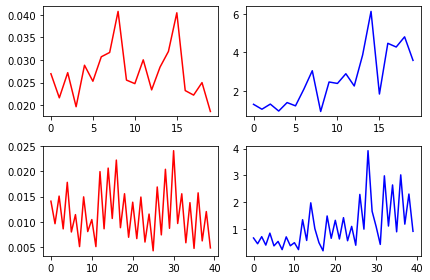

In [44]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(2,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_wpos_GS_mean_plt,color="red")
axes[0,1].plot(A_wpos_wo_GS_mean_plt,color="blue")
axes[1,0].plot(A_wneg_GS_mean_plt,color="red")
axes[1,1].plot(A_wneg_wo_GS_mean_plt,color="blue")
plt.show()

# 2. LSQのチェック

1. activationのgrad scale on/off

In [2]:
dir_name_w_GS = "./work_dir/cifar/LSQ/calculate_A_preresnet20_cifar100_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_x_LSQ_grad_scale-2/"
A_w_GS_mean_file_name = dir_name_w_GS + "A_mean.pt"
A_w_GS_std_file_name = dir_name_w_GS + "A_std.pt"

dir_name_wo_GS = "./work_dir/cifar/LSQ/calculate_A_preresnet20_cifar100_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_x_wo_grad_scale-2/"
A_wo_GS_mean_file_name = dir_name_wo_GS + "A_mean.pt"
A_wo_GS_std_file_name = dir_name_wo_GS + "A_std.pt"

In [3]:
A_w_GS_mean = torch.load(A_w_GS_mean_file_name)
print(A_w_GS_mean.size())
A_w_GS_std = torch.load(A_w_GS_std_file_name)
A_wo_GS_mean = torch.load(A_wo_GS_mean_file_name)
A_wo_GS_std = torch.load(A_wo_GS_std_file_name)

torch.Size([20, 1])


In [47]:
A_w_GS_mean_plt = torch.reshape(A_w_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wo_GS_mean_plt = torch.reshape(A_wo_GS_mean, (-1,)).to('cpu').detach().numpy().copy()

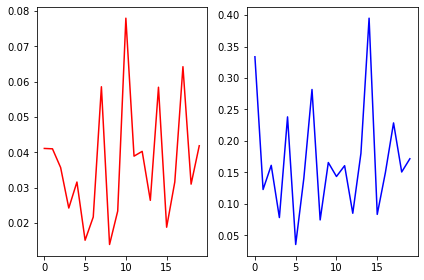

In [48]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_w_GS_mean_plt,color="red")
axes[0,1].plot(A_wo_GS_mean_plt,color="blue")
plt.show()

1. wightのgrad scale on/off

In [57]:
dir_name_w_GS = "./work_dir/cifar/LSQ/calculate_A_preresnet20_cifar100_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_w_GS_mean_file_name = dir_name_w_GS + "Aw_mean.pt"
A_w_GS_std_file_name = dir_name_w_GS + "Aw_std.pt"

dir_name_wo_GS = "./work_dir/cifar/LSQ/calculate_A_preresnet20_cifar100_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_wo_grad_scale_x_LSQ_grad_scale-2/"
A_wo_GS_mean_file_name = dir_name_wo_GS + "Aw_mean.pt"
A_wo_GS_std_file_name = dir_name_wo_GS + "Aw_std.pt"

In [58]:
A_w_GS_mean = torch.load(A_w_GS_mean_file_name)
A_w_GS_std = torch.load(A_w_GS_std_file_name)
A_wo_GS_mean = torch.load(A_wo_GS_mean_file_name)
A_wo_GS_std = torch.load(A_wo_GS_std_file_name)

In [59]:
A_w_GS_mean_plt = torch.reshape(A_w_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wo_GS_mean_plt = torch.reshape(A_wo_GS_mean, (-1,)).to('cpu').detach().numpy().copy()

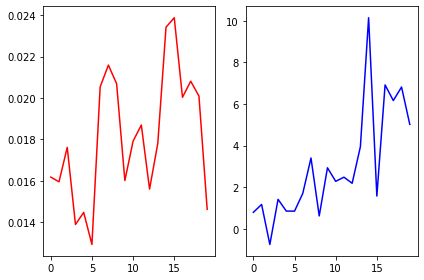

In [60]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_w_GS_mean_plt,color="red")
axes[0,1].plot(A_wo_GS_mean_plt,color="blue")
plt.show()